#### Generating additional data for unbalanced classes by jittering the original image

In many deep learning applications, we often come across data sets where one type of data may be seen more than other types. For example, in a traffic sign identification task, there may be more stop signs than speed limit signs. Therefore, in these cases, we need to make sure that the trained model is not biased towards the class that has more data. As an example, consider a data set where there are 5 speed limit signs and 20 stop signs. If the model predicts all signs to be stop signs, its accuracy is 80%. Further, f1-score of such a model is 0.88. Therefore, the model has high tendency to be biased toward the 'stop' sign class. In such cases, additional data can be generated to make the size of data sets similar. 

One way to collect more data is to take the picture of the same sign from different angles. This can be done easily in openCV by applying affine transformations, such as rotations, translations and shearing. Affine transformations are transformations where the parallel lines before transformation remain parallel after transformation. 

Below I present a function that can be used to generate jittered images. The function takes in the original image, range of angle rotation, range of tranlation and range of shearing and returns a jittered image. As the function chooses true tranformation values from a uniform distribution that is specified by these ranges, it 

Note, the same techniques can be applied using image generator in Keras. However, the transform_image() function provided here will help you play with the parameters and see whats happening under the hood. 

In [19]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

import numpy as np
%matplotlib inline
import matplotlib.image as mpimg

from matplotlib import pyplot as plt


from skimage import color
from skimage.transform import resize


In [4]:
import csv

with open("../pac_guide.csv") as file:
    reader = csv.reader(file)
    i = 0
    image_paths = []
    camera_nums = []
    labels = []
    
    for ind, row in enumerate(reader):
        index = row[0]
        camera_num = row[1]
        label = row[2]
        filename = row[3]
        image_paths.append(filename)
        labels.append(label)
        #if ind > 5:
        #    break
            



In [5]:
def depth_map_to_image(depth_map):
    img = cv2.normalize(depth_map, depth_map, 0, 1, cv2.NORM_MINMAX)
    img = np.array(img * 255, dtype=np.uint8)
    orig_img = img
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.applyColorMap(img, cv2.COLORMAP_OCEAN)
    #img = resize(img, 224, 224)

    return orig_img, img

In [6]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform(0.25, 0.75) #0.25
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    # Brightness 
    

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    img = augment_brightness_camera_images(img)
    
    return img

In [7]:
import os

def generate_ocean(dev_str): 

    curr_dev = np.load('../pac_arrays/' + dev_str + '.npy')
    #print(dev_02)
    curr_dev_0 = []
    curr_dev_1 = []
    for ind in curr_dev:
        if labels[ind] == '0':
            curr_dev_0.append(image_paths[ind])
        elif labels[ind] == '1':
            curr_dev_1.append(image_paths[ind])
    print(len(curr_dev))       
    print(len(curr_dev_0))
    print(len(curr_dev_1))

    num_transforms_needed = len(curr_dev_0) // len(curr_dev_1)
    print(num_transforms_needed)

    directory = '../' + dev_str + '_ocean/'
    if not os.path.exists(directory):
        os.makedirs(directory)

    directory1 = '../' + dev_str + '_ocean/1/'
    if not os.path.exists(directory1):
        os.makedirs(directory1)

    directory0 = '../' + dev_str + '_ocean/0/'
    if not os.path.exists(directory0):
        os.makedirs(directory0)

    directory_transforms = '../' + dev_str + '_ocean/transforms/'
    if not os.path.exists(directory_transforms):
        os.makedirs(directory_transforms)


    for i, filestr in enumerate(curr_dev_1):
        data = np.load(filestr)
        depth_map = data['x'].astype(np.float32)
        orig_img, ocean = depth_map_to_image(depth_map)
        ocean = resize(ocean, (224, 224), mode='constant')
        oceanfile = '../' + dev_str + '_ocean/1/' + str(i) + '.png'
        #print(oceanfile)
        plt.imsave(oceanfile, ocean)

    for i, filestr in enumerate(curr_dev_0):
        data = np.load(filestr)
        depth_map = data['x'].astype(np.float32)
        orig_img, ocean = depth_map_to_image(depth_map)
        ocean = resize(ocean, (224, 224), mode='constant')
        oceanfile = '../' + dev_str + '_ocean/0/' + str(i) + '.png'
        #print(oceanfile)
        plt.imsave(oceanfile, ocean)


    for i in range(len(curr_dev_1)):

        image = mpimg.imread('../' + dev_str + '_ocean/1/' + str(i) + '.png')
        oceanfile = '../' + dev_str + '_ocean/transforms/' + str(i) + '_0.png'
        plt.imsave(oceanfile, image)

        for j in range(1, num_transforms_needed):

            img = transform_image(image,5,5,5)
            oceanfile = '../' + dev_str + '_ocean/transforms/' + str(i) + '_' + str(j) + '.png'
            plt.imsave(oceanfile, img)


In [8]:

def generate_test_ocean(dev_str): 

    curr_dev = np.load('../pac_arrays/' + dev_str + '.npy')
    #print(dev_02)
    curr_dev_0 = []
    curr_dev_1 = []
    for ind in curr_dev:
        if labels[ind] == '0':
            curr_dev_0.append(image_paths[ind])
        elif labels[ind] == '1':
            curr_dev_1.append(image_paths[ind])
    print(len(curr_dev))       
    print(len(curr_dev_0))
    print(len(curr_dev_1))

    num_transforms_needed = len(curr_dev_0) // len(curr_dev_1)
    print(num_transforms_needed)

    directory = '../' + dev_str + '_ocean/'
    if not os.path.exists(directory):
        os.makedirs(directory)

    directory1 = '../' + dev_str + '_ocean/1/'
    if not os.path.exists(directory1):
        os.makedirs(directory1)

    directory0 = '../' + dev_str + '_ocean/0/'
    if not os.path.exists(directory0):
        os.makedirs(directory0)


    for i, filestr in enumerate(curr_dev_1):
        data = np.load(filestr)
        depth_map = data['x'].astype(np.float32)
        orig_img, ocean = depth_map_to_image(depth_map)
        ocean = resize(ocean, (224, 224), mode='constant')
        oceanfile = '../' + dev_str + '_ocean/1/' + str(i) + '.png'
        #print(oceanfile)
        plt.imsave(oceanfile, ocean)

    for i, filestr in enumerate(curr_dev_0):
        data = np.load(filestr)
        depth_map = data['x'].astype(np.float32)
        orig_img, ocean = depth_map_to_image(depth_map)
        ocean = resize(ocean, (224, 224), mode='constant')
        oceanfile = '../' + dev_str + '_ocean/0/' + str(i) + '.png'
        #print(oceanfile)
        plt.imsave(oceanfile, ocean)



In [10]:
files = ['02', '04', '06', '08', '11', '15', '23', '39', '52', '59', '62', '63', '72']


In [127]:

for file in files:
    generate_ocean('train_' + file)
    

1980
1829
151
12
1980
1783
197
9
1980
1240
740
1
1980
1766
214
8
1980
1883
97
19
1980
1976
4
494
1980
1486
494
3
1980
1967
13
151
1980
1696
284
5
1980
1953
27
72
1980
1545
435
3
1980
1397
583
2
1980
1433
547
2


In [132]:
for file in files:
    generate_test_ocean('test_' + file)

660
603
57
10
660
599
61
9
660
406
254
1
660
594
66
9
660
635
25
25
660
657
3
219
660
514
146
3
660
654
6
109
660
568
92
6
660
650
10
65
660
497
163
3
660
451
209
2
660
477
183
2


In [20]:
#Moved the ocean files to /pac_augmented so it can be accessed from disk

with open('../pac_transform_guide.csv', 'w') as f:

    counter = 0

    for file in files:
        train_str = 'train_' + file
        curr_train = np.load('../pac_arrays/' + train_str + '.npy')
        #print(dev_02)
        curr_train_0 = []
        curr_train_1 = []
        for ind in curr_train:
            if labels[ind] == '0':
                curr_train_0.append(image_paths[ind])
            elif labels[ind] == '1':
                curr_train_1.append(image_paths[ind])
        #print(len(curr_dev))       
        #print(len(curr_dev_0))
        #print(len(curr_dev_1))

        train_num_transforms_needed = len(curr_train_0) // len(curr_train_1)

        train_directory1 = '/pac_augmented/' + train_str + '_ocean/1/'
        train_directory0 = '/pac_augmented/' + train_str + '_ocean/0/'
        train_directory_transforms = '/pac_augmented/' + train_str + '_ocean/transforms/'

        #########################################################################################


        test_str = 'test_' + file

        curr_test = np.load('../pac_arrays/' + test_str + '.npy')
        #print(dev_02)
        curr_test_0 = []
        curr_test_1 = []
        for ind in curr_test:
            if labels[ind] == '0':
                curr_test_0.append(image_paths[ind])
            elif labels[ind] == '1':
                curr_test_1.append(image_paths[ind])


        #print(len(curr_dev))       
        #print(len(curr_dev_0))
        #print(len(curr_dev_1))

        test_num_transforms_needed = len(curr_test_0) // len(curr_test_1)
        #print(num_transforms_needed)

        test_directory1 = '/pac_augmented/' + test_str + '_ocean/1/'
        test_directory0 = '/pac_augmented/' + test_str + '_ocean/0/'
        test_directory_transforms = '/pac_augmented/' + test_str + '_ocean/transforms/'

        #########################################################################################

        print(train_str)

        ocean_train_1 = []
        for i, filestr in enumerate(curr_train_1):
            oceanfile = '/pac_augmented/' + train_str + '_ocean/1/' + str(i) + '.png'
            f.write(str(counter) + ',' + oceanfile + "," + "1\n")
            ocean_train_1.append(counter)
            counter += 1
        np.save('../pac_augment_arrays/ocean_1_' + train_str, np.random.permutation(ocean_train_1))
        #print(counter)
            

        #counter = 0
        ocean_train_0 = []
        for i, filestr in enumerate(curr_train_0):
            oceanfile = '/pac_augmented/' + train_str + '_ocean/0/' + str(i) + '.png'
            f.write(str(counter) + ',' + oceanfile + "," + "0\n")
            ocean_train_0.append(counter)
            counter += 1
        np.save('../pac_augment_arrays/ocean_0_' + train_str, np.random.permutation(ocean_train_0))
        print(counter)

        #counter = 0
        ocean_train_transforms = []
        for i in range(len(curr_train_1)):
            oceanfile = '/pac_augmented/' + train_str + '_ocean/transforms/' + str(i) + '_0.png'
            f.write(str(counter) + ',' + oceanfile + "," + "1\n")
            ocean_train_transforms.append(counter)
            counter += 1
            
            for j in range(1, train_num_transforms_needed):
                oceanfile = '/pac_augmented/' + train_str + '_ocean/transforms/' + str(i) + '_' + str(j) + '.png'
                f.write(str(counter) + ',' + oceanfile + "," + "1\n")
                ocean_train_transforms.append(counter)
                counter += 1
        np.save('../pac_augment_arrays/ocean_transforms_' + train_str, np.random.permutation(ocean_train_transforms))
        print(counter)

        #########################################################################################

        print(test_str)

        #counter = 0
        ocean_test_1 = []
        for i, filestr in enumerate(curr_test_1):
            oceanfile = '/pac_augmented/' + test_str + '_ocean/1/' + str(i) + '.png'
            f.write(str(counter) + ',' + oceanfile + "," + "1\n")
            ocean_test_1.append(counter)
            counter += 1

        np.save('../pac_augment_arrays/ocean_1_' + test_str, np.random.permutation(ocean_test_1))
        print(counter)

        #counter = 0
        ocean_test_0 = []
        for i, filestr in enumerate(curr_test_0):
            oceanfile = '/pac_augmented/' + test_str + '_ocean/0/' + str(i) + '.png'
            f.write(str(counter) + ',' + oceanfile + "," + "0\n")
            ocean_test_0.append(counter)
            counter += 1
        np.save('../pac_augment_arrays/ocean_0_' + test_str, np.random.permutation(ocean_test_0))
        print(counter)
        
    f.close()


    


train_02
1980
3792
test_02
3849
4452
train_04
6432
8205
test_04
8266
8865
train_06
10845
11585
test_06
11839
12245
train_08
14225
15937
test_08
16003
16597
train_11
18577
20420
test_11
20445
21080
train_15
23060
25036
test_15
25039
25696
train_23
27676
29158
test_23
29304
29818
train_39
31798
33761
test_39
33767
34421
train_52
36401
37821
test_52
37913
38481
train_59
40461
42405
test_59
42415
43065
train_62
45045
46350
test_62
46513
47010
train_63
48990
50156
test_63
50365
50816
train_72
52796
53890
test_72
54073
54550


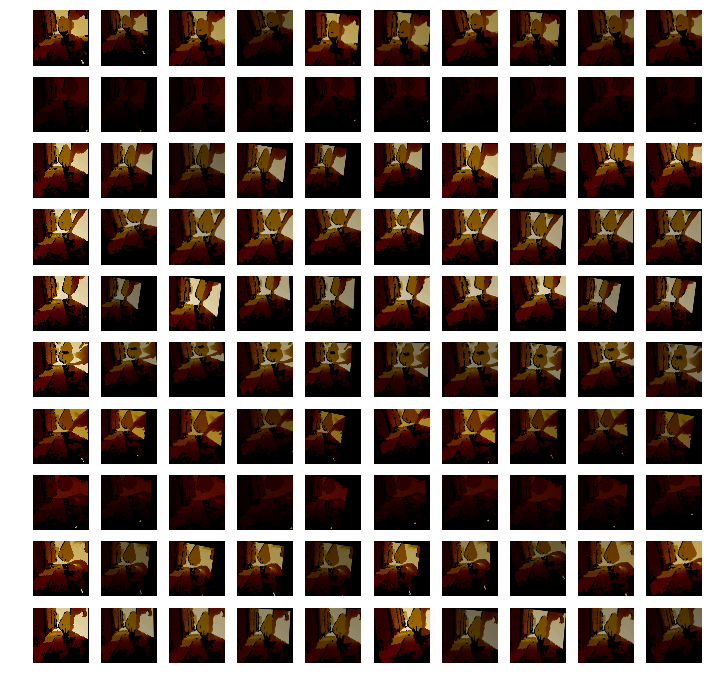

In [115]:
#DONT USE
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(10):
    ax1 = plt.subplot(gs1[(i*10)])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    image = mpimg.imread('../' + dev_str + '_ocean/1/' + str(i) + '.png')
    
    plt.subplot(10,10,(i*10)+1)
    plt.imshow(image)
    plt.axis('off')

    oceanfile = '../' + dev_str + '_ocean/transforms/' + str(i) + '_0.png'
    #print(oceanfile)

    #print(oceanfile)
    plt.imsave(oceanfile, img)

    for j in range(1, 10):
        ax1 = plt.subplot(gs1[(i*10) + j])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')



        #image = mpimg.imread('../dev02_ocean/1/' + str(i) + '.png')

        #img = transform_image(image,20,10,5)
        img = transform_image(image,5,5,5)

        plt.subplot(10,10,(i*10) + j+1)
        plt.imshow(img)
        plt.axis('off')

        oceanfile = '../' + dev_str + '_ocean/transforms/' + str(i) + '_' + str(j) + '.png'
        #print(oceanfile)

        #print(oceanfile)
        plt.imsave(oceanfile, img)

#plt.show()

In [ ]:
dev_str = 'dev_04'